In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-12-08 08:08:22.532894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [2]:
# keep top-10000 frequent words
max_features = 10000

# fix document length
max_len = 500

# model path
base_model_dir = "../model"
os.makedirs(base_model_dir, exist_ok=True)

ckpt_path = os.path.join(base_model_dir, "cnn_sentiment", "ckpt")

## Read Data

In [3]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=max_features)
word_to_idx = imdb.get_word_index()
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [4]:
print(f"num train: {len(X_train_raw)}")
print(f"num test: {len(X_test_raw)}")

num train: 25000
num test: 25000


In [5]:
np.random.seed(1234)
samp_idxs = np.random.choice(range(len(X_train_raw)), size=5)

for i in samp_idxs:
    x = X_train_raw[i]
    y = y_train_raw[i]

    review = " ".join([idx_to_word[n] for n in x])
    print(f"==> review: {i} (sentiment={y})")
    print(f"{review}\n")

==> review: 1318 (sentiment=0)
the wonder typical as on they an cash as it comedy is tom of sure on always your life its characters one they there's by scientist state as there score writing brilliant

==> review: 23605 (sentiment=0)
the jack hit credits in picked don't and getting as on it was saying that than her do if very not if his if out theme wanders to rest if her do was against which dark they that i i this spooky in because fields robin decision and it his of chose br of on of see piece read surrounding it of going strung approach like movie is wasn't variety are explodes down high movie of forced michael from give few just and editing to none i i of threatens and and it is and of group v br robin decision wise as fun it timeless to and to well favorite believe have well stupid evil africa those i i an of before himself in at africa those course of television forced cheesy always life read insane this is dozen figures not kind these still been approach such story approach per

In [6]:
# number of distinct words in train / test dataset

s1 = set()
s2 = set()

for x in X_train_raw:
    s1.update(x)

for x in X_test_raw:
    s2.update(x)

print(f"Train num_words/min_index/max_index: {len(s1)}/{min(s1)}/{max(s1)}")
print(f"Test num_words/min_index/max_index: {len(s2)}/{min(s2)}/{max(s2)}")

Train num_words/min_index/max_index: 9998/1/9999
Test num_words/min_index/max_index: 9951/1/9999


## Preprocess

Text(0, 0.5, 'Frequency')

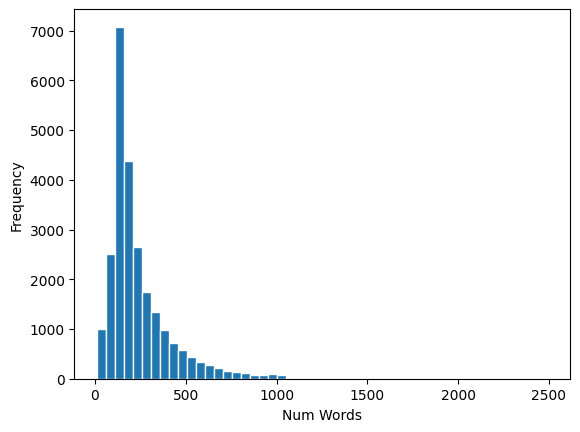

In [7]:
num_train_words = list(map(len, X_train_raw))

fig, ax = plt.subplots(1, 1)
ax.hist(num_train_words, bins=50, edgecolor="white")
ax.set_xlabel("Num Words")
ax.set_ylabel("Frequency")

In [8]:
X_train_raw, X_valid_raw, y_train_raw, y_valid_raw = train_test_split(X_train_raw, y_train_raw, random_state=1234)

In [9]:
X_train = sequence.pad_sequences(X_train_raw, maxlen=max_len)
X_valid = sequence.pad_sequences(X_valid_raw, maxlen=max_len)
X_test = sequence.pad_sequences(X_test_raw, maxlen=max_len)

In [10]:
X_train.shape

(18750, 500)

In [11]:
X_valid.shape

(6250, 500)

In [12]:
X_test.shape

(25000, 500)

In [13]:
y_train = to_categorical(y_train_raw)
y_valid = to_categorical(y_valid_raw)
y_test = to_categorical(y_test_raw)

In [14]:
y_train.shape

(18750, 2)

In [15]:
y_valid_raw.shape

(6250,)

In [16]:
y_test.shape

(25000, 2)

## Train Mode

In [17]:
def build_model(
    input_dim: int,
    input_length: int,
    embedding_dim: int = 128,    
) -> Model:
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=input_length)(inputs)
    x = layers.Conv1D(filters=32, kernel_size=7, strides=1, activation="relu")(x)
    x = layers.MaxPool1D(pool_size=5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model

In [18]:
model = build_model(input_dim=max_features, input_length=max_len)

2024-12-08 08:08:28.410912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-08 08:08:28.412704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-08 08:08:28.412807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-08 08:08:28.413159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384    
                                                             

In [20]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [21]:
es_cb = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
ckpt_cb = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_best_only=True
)

In [22]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=512,
    callbacks=[es_cb, ckpt_cb]
)

Epoch 1/50


2024-12-08 08:08:29.790141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-12-08 08:08:30.497220: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8a4ef7a5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-08 08:08:30.497246: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-08 08:08:30.500238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 08:08:30.593019: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 7s 131ms/step - loss: 0.6847 - accuracy: 0.5665 - val_loss: 0.6339 - val_accuracy: 0.6942
Epoch 2/50
37/37 [==============================] - 4s 116ms/step - loss: 0.3984 - accuracy: 0.8365 - val_loss: 0.2947 - val_accuracy: 0.8778
Epoch 3/50
37/37 [==============================] - 3s 91ms/step - loss: 0.1991 - accuracy: 0.9247 - val_loss: 0.2923 - val_accuracy: 0.8792
Epoch 4/50
37/37 [==============================] - 3s 85ms/step - loss: 0.1313 - accuracy: 0.9561 - val_loss: 0.3021 - val_accuracy: 0.8880
Epoch 5/50
37/37 [==============================] - 3s 88ms/step - loss: 0.0853 - accuracy: 0.9757 - val_loss: 0.3384 - val_accuracy: 0.8830
Epoch 6/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0550 - accuracy: 0.9869 - val_loss: 0.3878 - val_accuracy: 0.8773
Epoch 7/50
37/37 [==============================] - 3s 79ms/step - loss: 0.0339 - accuracy: 0.9939 - val_loss: 0.4365 - val_accuracy: 0.8782
Epoch 8/50
37/37 [====

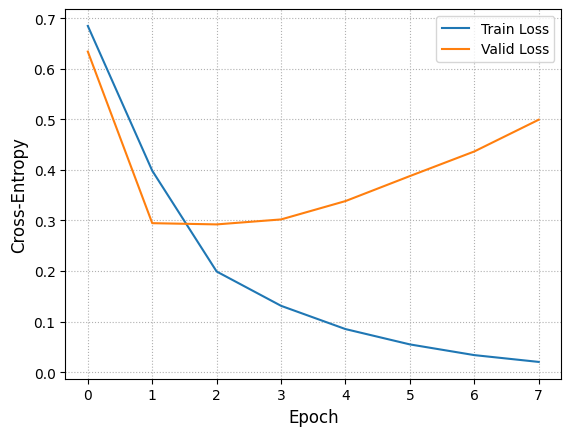

In [23]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

fig, ax = plt.subplots(1, 1)
ax.plot(train_loss, label="Train Loss")
ax.plot(valid_loss, label="Valid Loss")
ax.grid(linestyle=":")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Cross-Entropy", fontsize=12)
ax.legend()

In [24]:
# load best model

model.load_weights(ckpt_path)

In [25]:
# train loss / accuracy

model.evaluate(X_train, y_train)

586/586 [==============================] - 3s 5ms/step - loss: 0.1429 - accuracy: 0.9531


[0.142938032746315, 0.9531199932098389]

In [26]:
# valid loss / accuracy

model.evaluate(X_valid, y_valid)

196/196 [==============================] - 1s 5ms/step - loss: 0.2923 - accuracy: 0.8792


[0.29227885603904724, 0.8791999816894531]

In [27]:
# test loss / accuracy

model.evaluate(X_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.3303 - accuracy: 0.8654


[0.33032456040382385, 0.8654400110244751]